# Fit Parametric Copula
The purpose of this notebook is to find the best fitting Copula. The overall strategy is to maximize the likelihood. (However, there are hypothesis testing type goodness of fit testing procedures are proposed, detail please refer to )


## Fitting Marginals
First, we fit the data to different distributions to obtain the best fitting distributions' paramters. Then, we compute the KS statistis of each distributions and pick the best one to proceed. 

In [1]:
import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
import pandas as pd
import numpy as np
import seaborn as sns
data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

,Unnamed: 0,Last Price_btc,Open Price_btc,High Price_btc,Low Price_btc,BTC1 Curncy - Volume,Last Price_brr,Open Price_brr,High Price_brr,Low Price_brr,price_crix,return_btc,return_brr,return_crix
0,2020-09-04,10480,10730.0,10740.0,10355.0,13711.0,10273.83,10273.83,10273.83,10273.83,29614.314902,-0.022642,-0.056452,-0.109754
1,2020-09-03,10720,11710.0,11710.0,10840.0,15412.0,10870.49,10870.49,10870.49,10870.49,33049.664458,-0.066752,-0.040962,-0.046514
2,2020-09-02,11460,12405.0,12405.0,11530.0,17210.0,11325.01,11325.01,11325.01,11325.01,34623.237089,-0.052274,-0.046365,0.023061
3,2020-09-01,12075,12050.0,12450.0,12050.0,8919.0,11862.46,11862.46,11862.46,11862.46,33833.920615,0.020076,0.012073,-0.001434
4,2020-08-31,11835,11735.0,11915.0,11705.0,4865.0,11720.10,11720.10,11720.10,11720.10,33882.473739,0.017473,0.023398,0.033484


In [7]:
M = max(data.iloc[:,-1])
m = min(data.iloc[:,-1])
size = 3000
x = np.linspace(m, M, size)
dist_names = ['norm', 'lognorm', 't', 'laplace']

In [29]:
def fit_marginals(data, dist_names = ['norm', 'lognorm', 't', 'laplace']):
    dist_arr = []
    KS_arr = []
    param_arr = []
    for dist_name in dist_names:
        dist = getattr(scipy.stats, dist_name)
        dist_arr.append(dist)
        param = dist.fit(data)
        param_arr.append(param)
        KS = st.kstest(data, dist_name, args=param)
        KS_arr.append(KS)
        pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
        plt.plot(x, pdf_fitted, label=dist_name)

    sns.distplot(data, label='empirical')
    plt.legend()
    return dist_names, dist_arr, KS_arr, param_arr

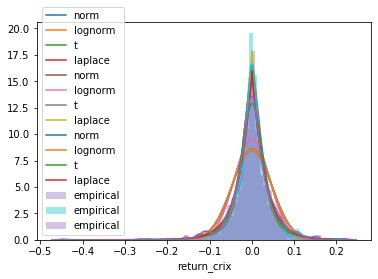

In [30]:
btc_result = fit_marginals(data.iloc[:,-3])
brr_result = fit_marginals(data.iloc[:,-2])
crix_result = fit_marginals(data.iloc[:,-1])

In [31]:
btc_KS = [round(result[0], 4) for result in btc_result[-1]]
brr_KS = [round(result[0], 4) for result in brr_result[-1]]
crix_KS = [round(result[0], 4) for result in crix_result[-1]]

btc_KS_pvalue = [round(result[1], 4) for result in btc_result[-1]]
brr_KS_pvalue = [round(result[1], 4) for result in brr_result[-1]]
crix_KS_pvalue = [round(result[1], 4) for result in crix_result[-1]]

In [32]:
KSs = pd.DataFrame({'btc':btc_KS, 'brr':brr_KS, 'crix':crix_KS}, index=dist_names).T
KS_pvalues = pd.DataFrame({'btc':btc_KS_pvalue, 'brr':brr_KS_pvalue, 'crix':crix_KS_pvalue}, index=dist_names).T

In [33]:
KSs.columns = ['KS' for _ in range(len(dist_names))]
KS_pvalues.columns = ['P-values' for _ in range(len(dist_names))]
KS_and_Pvalues = [pd.concat({'KS':KSs.iloc[:,i], "P-value":KS_pvalues.iloc[:,i]},axis=1) for i in range(len(dist_names))]
pd.concat(dict([(dist_names[i], KS_and_Pvalues[i]) for i in range(len(dist_names))]), axis=1)

laplace         lognorm             norm               t        
          KS P-value      KS  P-value      KS P-value      KS P-value
btc  -0.0000  0.0303  0.0039 -11.8758  0.0004  0.0462  2.1322  0.0002
brr   0.0006  0.0280  0.0031 -13.5006  0.0003  0.0418  2.2904  0.0010
crix  0.0006  0.0313  0.0011 -43.8815 -0.0001  0.0471  2.7944  0.0007

### Decisions
btc future: t distribution

btc reference rate: t distribution (but p-value is not satisfying)

crix reference rate: laplace distribution (but p-value is not satisfying)

## Fitting Copula

We will use the $\theta-\tau$ relationship to determine the parameter, and then calculate the corresponding likelihood. 

We are interested in two pairs of bivariate copula:
- brr, btc future, and
- crix, btc future

The link between $\tau$ and $\theta$ (Genest & Riverst, 1993)
- Clayton
$\tau = \theta/(\theta+2)$

- Frank
$ \tau = 1+ 4(D_1(\theta)-1)/\theta$, where $D_1$ is the Debye function of order 1

- Gumbel
$ \tau = \theta / (\theta+1)$

https://mediatum.ub.tum.de/doc/1119201/1119201.pdf

In [45]:
tau_1 = st.kendalltau(data.return_brr, data.return_btc)[0]
tau_2 = st.kendalltau(data.return_crix, data.return_btc)[0]

In [46]:
def Clayton_copula_density(u, v, theta):
    A = (1+theta)*(u*v)**(-1-theta)
    B = (-1+u**-theta+v**-theta)**(-2-1/theta)
    return A*B

def Gumbel_copula(u,v, theta):
    t1 = (-np.log(u))**theta
    t2 = (-np.log(v))**theta
    return np.exp((-(t1+t2))**(1/theta))

def Gumbel_copula_density(u,v, theta):
    t1 = (-np.log(u))**theta
    t2 = (-np.log(v))**theta
    A = (Gumbel_copula(u,v,theta)/(u*v))*(t1+t2)**(-2+2/theta)
    B = (np.log(u)*np.log(v))**(theta-1)
    C = 1+ (theta-1)*(t1+t2)**(-1/theta)
    return A*B*C

In [47]:
u = brr_result[1][2].cdf(data.return_brr,df=brr_result[-1][2][0])
v = btc_result[1][2].cdf(data.return_btc,df=btc_result[-1][2][0])

In [54]:
# Clayton
theta_clayton = 2*tau_1 / (1-tau_1)
theta_gumbel = 1*tau_1 / (1-tau_1)

u = brr_result[1][2].cdf(data.return_brr,df=brr_result[-1][2][0])
v = btc_result[1][2].cdf(data.return_btc,df=btc_result[-1][2][0])
clayton_likelihood = np.sum(np.log(Clayton_copula_density(u,v, theta)))

clayton_likelihood = np.sum(np.log(Clayton_copula_density(u,v, theta_clayton)))
gumbel_likelihood = np.sum(np.log(Gumbel_copula_density(u,v, theta_gumbel)))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


In [57]:
clayton_likelihood

338.47412611738685